# DeepLife Cell Segmentation project


# Setup

In [3]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore # CHANGED: Import from .utils.metrics
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from tqdm import tqdm
from tqdm.notebook import tqdm # NOTE: For Colab

In [2]:
import skimage.io


In [4]:
# Set global variables

# TIP: You can create a shortcut of the official dataset to your MyDrive folder
# https://drive.google.com/drive/folders/1NFplvkQzc_nHFwpnB55lw2nD6coc91VV?usp=drive_link
DATA_DIR = "/data/"

TRAIN_IMG_DIR = f"data/Training/images/"
TRAIN_LBL_DIR = f"data/Training/labels/"
TEST_IMG_DIR = f"data/Tuning/images/"
TEST_LBL_DIR = f"data/Tuning/labels/"
MODEL_SAVE_PATH = "swinunet_celldet_best.pth"

LEARNING_RATE = 1e-4
BATCH_SIZE = 2 # Adjust based on your MacBook's memory
NUM_EPOCHS = 25 # Start with a smaller number for testing, e.g., 5-10
IMG_HEIGHT = 448 # Changed from 256 to a multiple of 192 (32*6)
IMG_WIDTH = 448  # Changed from 256 to a multiple of 192 (32*6)
ENCODER_NAME = "resnet34" # A good balance of performance and speed


In [5]:
# Set device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU device.")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
    print("Using MPS device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU or MPS available, using CPU device.")

print(f"Final selected device: {DEVICE}")

Using CUDA GPU device.
Final selected device: cuda


In [6]:
# Dataset class
class CellDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_name = f"{base_name}_label.tiff"
        label_path = os.path.join(self.label_dir, label_name)

        image = skimage.io.imread(img_path)
        label = skimage.io.imread(label_path)
        original_label_shape_for_debug = label.shape

        # Ensure image is 2D (grayscale) then expand to (H,W,1) for albumentations
        processed_image = image
        if processed_image.ndim == 3:
            if processed_image.shape[-1] == 1: # (H,W,1)
                processed_image = processed_image[..., 0]
            elif processed_image.shape[-1] > 1: # (H,W,C) e.g. RGB
                print(f"Warning: Image {img_path} has shape {processed_image.shape}. Taking first channel.")
                processed_image = processed_image[..., 0]
        # Now processed_image is (H,W) or should be. Add channel dim for albumentations.
        if processed_image.ndim == 2:
            processed_image = np.expand_dims(processed_image, axis=-1) # (H,W) -> (H,W,1)
        else:
            raise ValueError(f"Image {img_path} could not be processed to (H,W,1). Shape: {image.shape}")

        # Convert to float32 for Albumentations compatibility
        processed_image = processed_image.astype(np.float32)

        if label.ndim == 2: # Already (H,W)
            processed_label = label
        elif label.ndim == 3:
            # Heuristic: Check if first dimension is likely channels (C, H, W)
            if (label.shape[0] <= 4 and label.shape[0] < label.shape[1] and label.shape[0] < label.shape[2]):
                print(f"Info: Label {label_path} shape {original_label_shape_for_debug} interpreted as (C,H,W). Converting to 2D mask.")
                if label.shape[0] == 1: # (1,H,W)
                    processed_label = label[0, ...]
                else: # (C_multi,H,W), e.g. (4,H,W)
                    processed_label = np.any(label > 0, axis=0) # Reduce along channel axis -> (H,W) boolean
            # Heuristic: Check if last dimension is likely channels (H, W, C)
            elif (label.shape[-1] <= 4 and label.shape[-1] < label.shape[0] and label.shape[-1] < label.shape[1]):
                print(f"Info: Label {label_path} shape {original_label_shape_for_debug} interpreted as (H,W,C). Converting to 2D mask.")
                if label.shape[-1] == 1: # (H,W,1)
                    processed_label = label[..., 0]
                else: # (H,W,C_multi), e.g. (H,W,4)
                    processed_label = np.any(label > 0, axis=-1) # Reduce along channel axis -> (H,W) boolean
            else:
                raise ValueError(f"Label {label_path} has ambiguous 3D shape {original_label_shape_for_debug}. Cannot determine channel dimension.")
        else: # ndim not 2 or 3
            raise ValueError(f"Label {label_path} has unsupported ndim={label.ndim} (shape {original_label_shape_for_debug}). Expected 2D or 3D.")

        # Convert processed_label (which should now be 2D H,W numeric or boolean) to semantic mask {0, 1}
        semantic_label = (processed_label > 0).astype(np.uint8)

        if semantic_label.ndim != 2:
            raise RuntimeError(f"Critical: Semantic label for {label_path} is not 2D after processing. Shape: {semantic_label.shape}. Original label shape: {original_label_shape_for_debug}.")

        if self.transform:
            augmented = self.transform(image=processed_image, mask=semantic_label)
            image_tensor = augmented['image']
            mask_tensor = augmented['mask']
        else:
            # Basic to tensor conversion if no albumentations transform
            # This path might need ToTensorV2 if not using albumentations for consistency
            image_tensor = torch.from_numpy(processed_image.transpose(2,0,1)).float() # HWC -> CHW
            mask_tensor = torch.from_numpy(semantic_label).long()


        return image_tensor, mask_tensor.long() # Ensure mask is Long for loss/metrics


In [7]:
# Data Augmentation
def get_transforms(height, width, is_train=True):
    if is_train:
        transform = A.Compose([
            A.Resize(height, width),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(var_limit=50.0, p=0.3),  # Use a single float for var_limit
            A.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05),  # Remove alpha_affine
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])
    else:
        transform = A.Compose([
            A.Resize(height, width),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])
    return transform


In [8]:
from swin_unet_gray import SwinTransformerSys
import torch.nn as nn

def get_model(img_size=448, in_channels=1, classes=2):
    model = SwinTransformerSys(
        img_size=img_size,       
        patch_size=4,
        in_chans=in_channels,
        num_classes=classes,
        embed_dim=128,                    # from your hyperparameters
        depths=[2, 2, 2, 2],
        depths_decoder=[1, 2, 2, 2],      # mirror or customize as needed
        num_heads=[4, 8, 16, 32],         # from your hyperparameters
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        use_checkpoint=False,
        final_upsample="expand_first"
    )
    return model


c:\Users\lidzi\anaconda3\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [9]:
# Training Function
def train_one_epoch(model, loader, optimizer, loss_fn, metrics_fns, device):
    model.train()
    loop = tqdm(loader, desc="Training")

    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_fscore = 0.0

    for batch_idx, (images, masks) in enumerate(loop):
        images = images.to(device)
        masks = masks.to(device) # Shape (B, H, W)

        optimizer.zero_grad()
        predictions = model(images) # Shape (B, C, H, W)

        # DEBUG: Print shapes before metric calculation
        if batch_idx == 0: # Print only for the first batch to avoid clutter
            print(f"DEBUG: predictions.shape: {predictions.shape}") # Expected: (B, 2, H, W)
            print(f"DEBUG: masks.shape: {masks.shape}")             # Expected: (B, H, W)
            print(f"DEBUG: masks.dtype: {masks.dtype}")           # Expected: torch.int64 (long)
            if masks.numel() > 0:
                 print(f"DEBUG: masks min/max values: {masks.min()}, {masks.max()}") # Expected: 0, 1

        loss = loss_fn(predictions, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate metrics
        # For multiclass, metrics expect predictions as logits/probs and masks as class indices
        masks_one_hot = torch.nn.functional.one_hot(masks, num_classes=2).permute(0, 3, 1, 2).float()
        iou_score = metrics_fns['iou'](predictions, masks_one_hot)
        f_score = metrics_fns['fscore'](predictions, masks_one_hot)

        epoch_iou += iou_score.item()
        epoch_fscore += f_score.item()

        loop.set_postfix(loss=loss.item(), iou=iou_score.item(), fscore=f_score.item())

    avg_loss = epoch_loss / len(loader)
    avg_iou = epoch_iou / len(loader)
    avg_fscore = epoch_fscore / len(loader)
    return avg_loss, avg_iou, avg_fscore

def validate_one_epoch(model, loader, loss_fn, metrics_fns, device):
    model.eval()
    loop = tqdm(loader, desc="Validation", leave=False) # NOTE: leave arg for Notebook

    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_fscore = 0.0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop): # Added batch_idx for debug print
            images = images.to(device)
            masks = masks.to(device)

            predictions = model(images)

            # DEBUG: Print shapes before metric calculation
            if batch_idx == 0: # Print only for the first batch
                print(f"DEBUG (Validation): predictions.shape: {predictions.shape}")
                print(f"DEBUG (Validation): masks.shape: {masks.shape}")
                print(f"DEBUG (Validation): masks.dtype: {masks.dtype}")
                if masks.numel() > 0:
                    print(f"DEBUG (Validation): masks min/max values: {masks.min()}, {masks.max()}")

            loss = loss_fn(predictions, masks)

            epoch_loss += loss.item()

            masks_one_hot = torch.nn.functional.one_hot(masks, num_classes=2).permute(0, 3, 1, 2).float()
            iou_score = metrics_fns['iou'](predictions, masks_one_hot)
            f_score = metrics_fns['fscore'](predictions, masks_one_hot)

            epoch_iou += iou_score.item()
            epoch_fscore += f_score.item()

            loop.set_postfix(val_loss=loss.item(), val_iou=iou_score.item(), val_fscore=f_score.item())

    avg_loss = epoch_loss / len(loader)
    avg_iou = epoch_iou / len(loader)
    avg_fscore = epoch_fscore / len(loader)

    return avg_loss, avg_iou, avg_fscore


In [10]:
# Plotting Function
def plot_predictions(model, dataset, device, num_samples=5, best_threshold=0.5): # ADDED best_threshold=0.5
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    if num_samples == 1: # Matplotlib returns a single Axes object if num_samples is 1
        axes = np.array([axes])


    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx] # This will apply test-time transforms

        # Original image for plotting (before normalization)
        # For simplicity, we'll plot the transformed input image
        # To plot the *very* original, you'd need to load it separately without normalization

        input_image_tensor = image.unsqueeze(0).to(device) # Add batch dim

        with torch.no_grad():
            pred_logits = model(input_image_tensor)
            # CORRECTED: Apply activation (softmax for multiclass) and then threshold
            probabilities = torch.softmax(pred_logits, dim=1).squeeze(0).cpu().numpy() # For PSPNet with 2 classes, softmax gives (C,H,W) probabilities
            # Assuming you want to threshold the probability of the foreground class (class 1)
            pred_mask = (probabilities[1, :, :] > best_threshold).astype(np.uint8) # Threshold on foreground probability

            # pred_logits = model(input_image_tensor)
            # pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()

        # Display input image (CHW -> HWC for matplotlib)
        # Input image is normalized, so appearance might be off.
        # For better visualization, denormalize or plot original.
        # Here, we plot the normalized input.
        img_to_plot = image.cpu().numpy().transpose(1, 2, 0)
        # Squeeze if it's (H,W,1) for grayscale imshow
        if img_to_plot.shape[-1] == 1:
            img_to_plot = img_to_plot.squeeze(-1)

        axes[i, 0].imshow(img_to_plot, cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_mask.cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# Training

In [11]:
# Create datasets with augmentations
train_transform = get_transforms(IMG_HEIGHT, IMG_WIDTH, is_train=True)
val_test_transform = get_transforms(IMG_HEIGHT, IMG_WIDTH, is_train=False)

train_dataset = CellDataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, transform=train_transform)
val_dataset = CellDataset(TEST_IMG_DIR, TEST_LBL_DIR, transform=val_test_transform)
test_dataset = CellDataset(TEST_IMG_DIR, TEST_LBL_DIR, transform=val_test_transform)

print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(val_dataset)} validation/test images.")

if not train_dataset or not val_dataset:
    print("Error: Empty dataset. Check image paths and data directories.")
    exit()


Found 447 training images.
Found 31 validation/test images.


C:\Users\lidzi\AppData\Local\Temp\ipykernel_22004\4057113336.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=50.0, p=0.3),  # Use a single float for var_limit


In [12]:

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize model, loss, optimizer, metrics
model = get_model()
model = model.to(DEVICE)
loss_fn = DiceLoss(mode='multiclass', from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
metrics = {
    "iou": IoU(threshold=0.5, activation="softmax2d"),
    "fscore": Fscore(threshold=0.5, activation="softmax2d")
}


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2


c:\Users\lidzi\anaconda3\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


In [13]:

best_val_iou = 0.0

# Lists for learning curves
train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_fscores, val_fscores = [], []

print(f"Starting training for {NUM_EPOCHS} epochs on {DEVICE}...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_iou, train_fscore = train_one_epoch(model, train_loader, optimizer, loss_fn, metrics, DEVICE)
    print(f"Train -> Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F-score: {train_fscore:.4f}")

    val_loss, val_iou, val_fscore = validate_one_epoch(model, val_loader, loss_fn, metrics, DEVICE)
    print(f"Val   -> Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F-score: {val_fscore:.4f}")

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_fscores.append(train_fscore)
    val_fscores.append(val_fscore)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH} (Best Val IoU: {best_val_iou:.4f})")


Starting training for 25 epochs on cuda...

Epoch 1/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5086, IoU: 0.7195, F-score: 0.8270


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.5202, IoU: 0.6821, F-score: 0.7928
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.6821)

Epoch 2/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5012, IoU: 0.7015, F-score: 0.8180


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.5258, IoU: 0.6359, F-score: 0.7510

Epoch 3/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5040, IoU: 0.6831, F-score: 0.8012


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.5230, IoU: 0.6989, F-score: 0.8014
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.6989)

Epoch 4/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5018, IoU: 0.7191, F-score: 0.8321


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.5066, IoU: 0.7183, F-score: 0.8165
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7183)

Epoch 5/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4793, IoU: 0.6621, F-score: 0.7866


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.5284, IoU: 0.5360, F-score: 0.6606

Epoch 6/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4914, IoU: 0.6457, F-score: 0.7734


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4865, IoU: 0.6524, F-score: 0.7686

Epoch 7/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4399, IoU: 0.7302, F-score: 0.8404


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4833, IoU: 0.6834, F-score: 0.7878

Epoch 8/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4429, IoU: 0.7383, F-score: 0.8453


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4763, IoU: 0.6041, F-score: 0.7371

Epoch 9/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4442, IoU: 0.7337, F-score: 0.8425


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4433, IoU: 0.6729, F-score: 0.7797

Epoch 10/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4368, IoU: 0.7438, F-score: 0.8492


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4630, IoU: 0.6745, F-score: 0.7810

Epoch 11/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4292, IoU: 0.7488, F-score: 0.8532


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4216, IoU: 0.6901, F-score: 0.7934

Epoch 12/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4158, IoU: 0.7699, F-score: 0.8665


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4154, IoU: 0.6927, F-score: 0.7960

Epoch 13/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4292, IoU: 0.7318, F-score: 0.8416


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4437, IoU: 0.6985, F-score: 0.7968

Epoch 14/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4261, IoU: 0.7407, F-score: 0.8479


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4086, IoU: 0.7004, F-score: 0.8005

Epoch 15/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4246, IoU: 0.7574, F-score: 0.8585


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3563, IoU: 0.6878, F-score: 0.7858

Epoch 16/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4187, IoU: 0.7758, F-score: 0.8683


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4169, IoU: 0.7223, F-score: 0.8130
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7223)

Epoch 17/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3984, IoU: 0.7893, F-score: 0.8786


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3554, IoU: 0.7332, F-score: 0.8203
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7332)

Epoch 18/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4329, IoU: 0.7808, F-score: 0.8729


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3252, IoU: 0.7218, F-score: 0.8139

Epoch 19/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4111, IoU: 0.7449, F-score: 0.8499


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3209, IoU: 0.7408, F-score: 0.8267
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7408)

Epoch 20/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4155, IoU: 0.7492, F-score: 0.8536


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3173, IoU: 0.7434, F-score: 0.8279
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7434)

Epoch 21/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4187, IoU: 0.7501, F-score: 0.8536


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.2933, IoU: 0.7480, F-score: 0.8312
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7480)

Epoch 22/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3950, IoU: 0.7563, F-score: 0.8580


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.2861, IoU: 0.7424, F-score: 0.8274

Epoch 23/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4141, IoU: 0.7537, F-score: 0.8562


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.4513, IoU: 0.7079, F-score: 0.8029

Epoch 24/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4148, IoU: 0.7789, F-score: 0.8717


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.3097, IoU: 0.7436, F-score: 0.8292

Epoch 25/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3978, IoU: 0.7640, F-score: 0.8626


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1
Val   -> Loss: 0.2834, IoU: 0.7491, F-score: 0.8305
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7491)


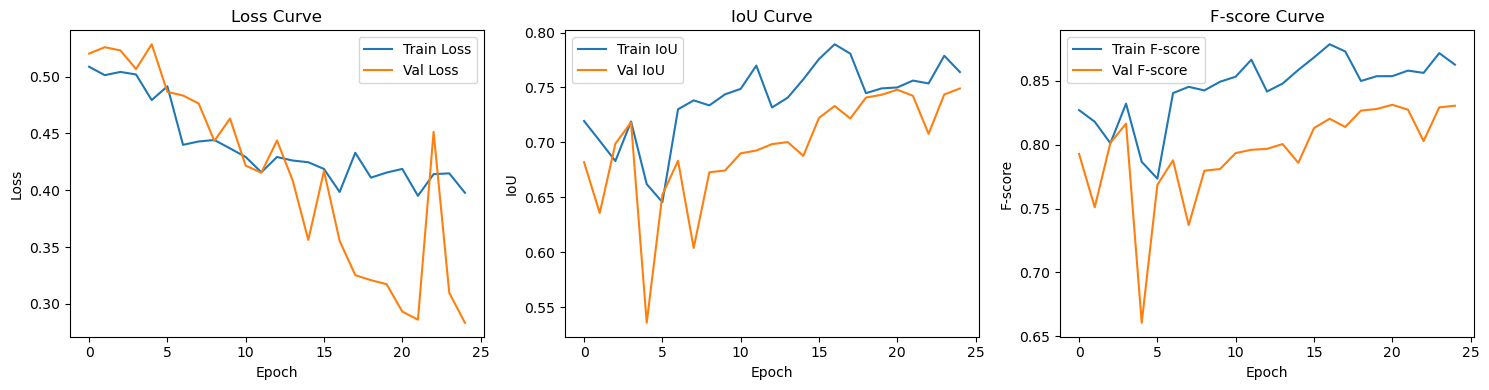

In [14]:

# Plot learning curves
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU Curve')

plt.subplot(1, 3, 3)
plt.plot(train_fscores, label='Train F-score')
plt.plot(val_fscores, label='Val F-score')
plt.xlabel('Epoch')
plt.ylabel('F-score')
plt.legend()
plt.title('F-score Curve')

plt.tight_layout()
plt.show()


# Testing


Loading best model for testing...


C:\Users\lidzi\AppData\Local\Temp\ipykernel_22004\2117837987.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_locati

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

DEBUG (Validation): predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG (Validation): masks.shape: torch.Size([2, 448, 448])
DEBUG (Validation): masks.dtype: torch.int64
DEBUG (Validation): masks min/max values: 0, 1

Test Results -> Loss: 0.2834, IoU: 0.7491, F-score (Dice): 0.8305

Plotting some test predictions...


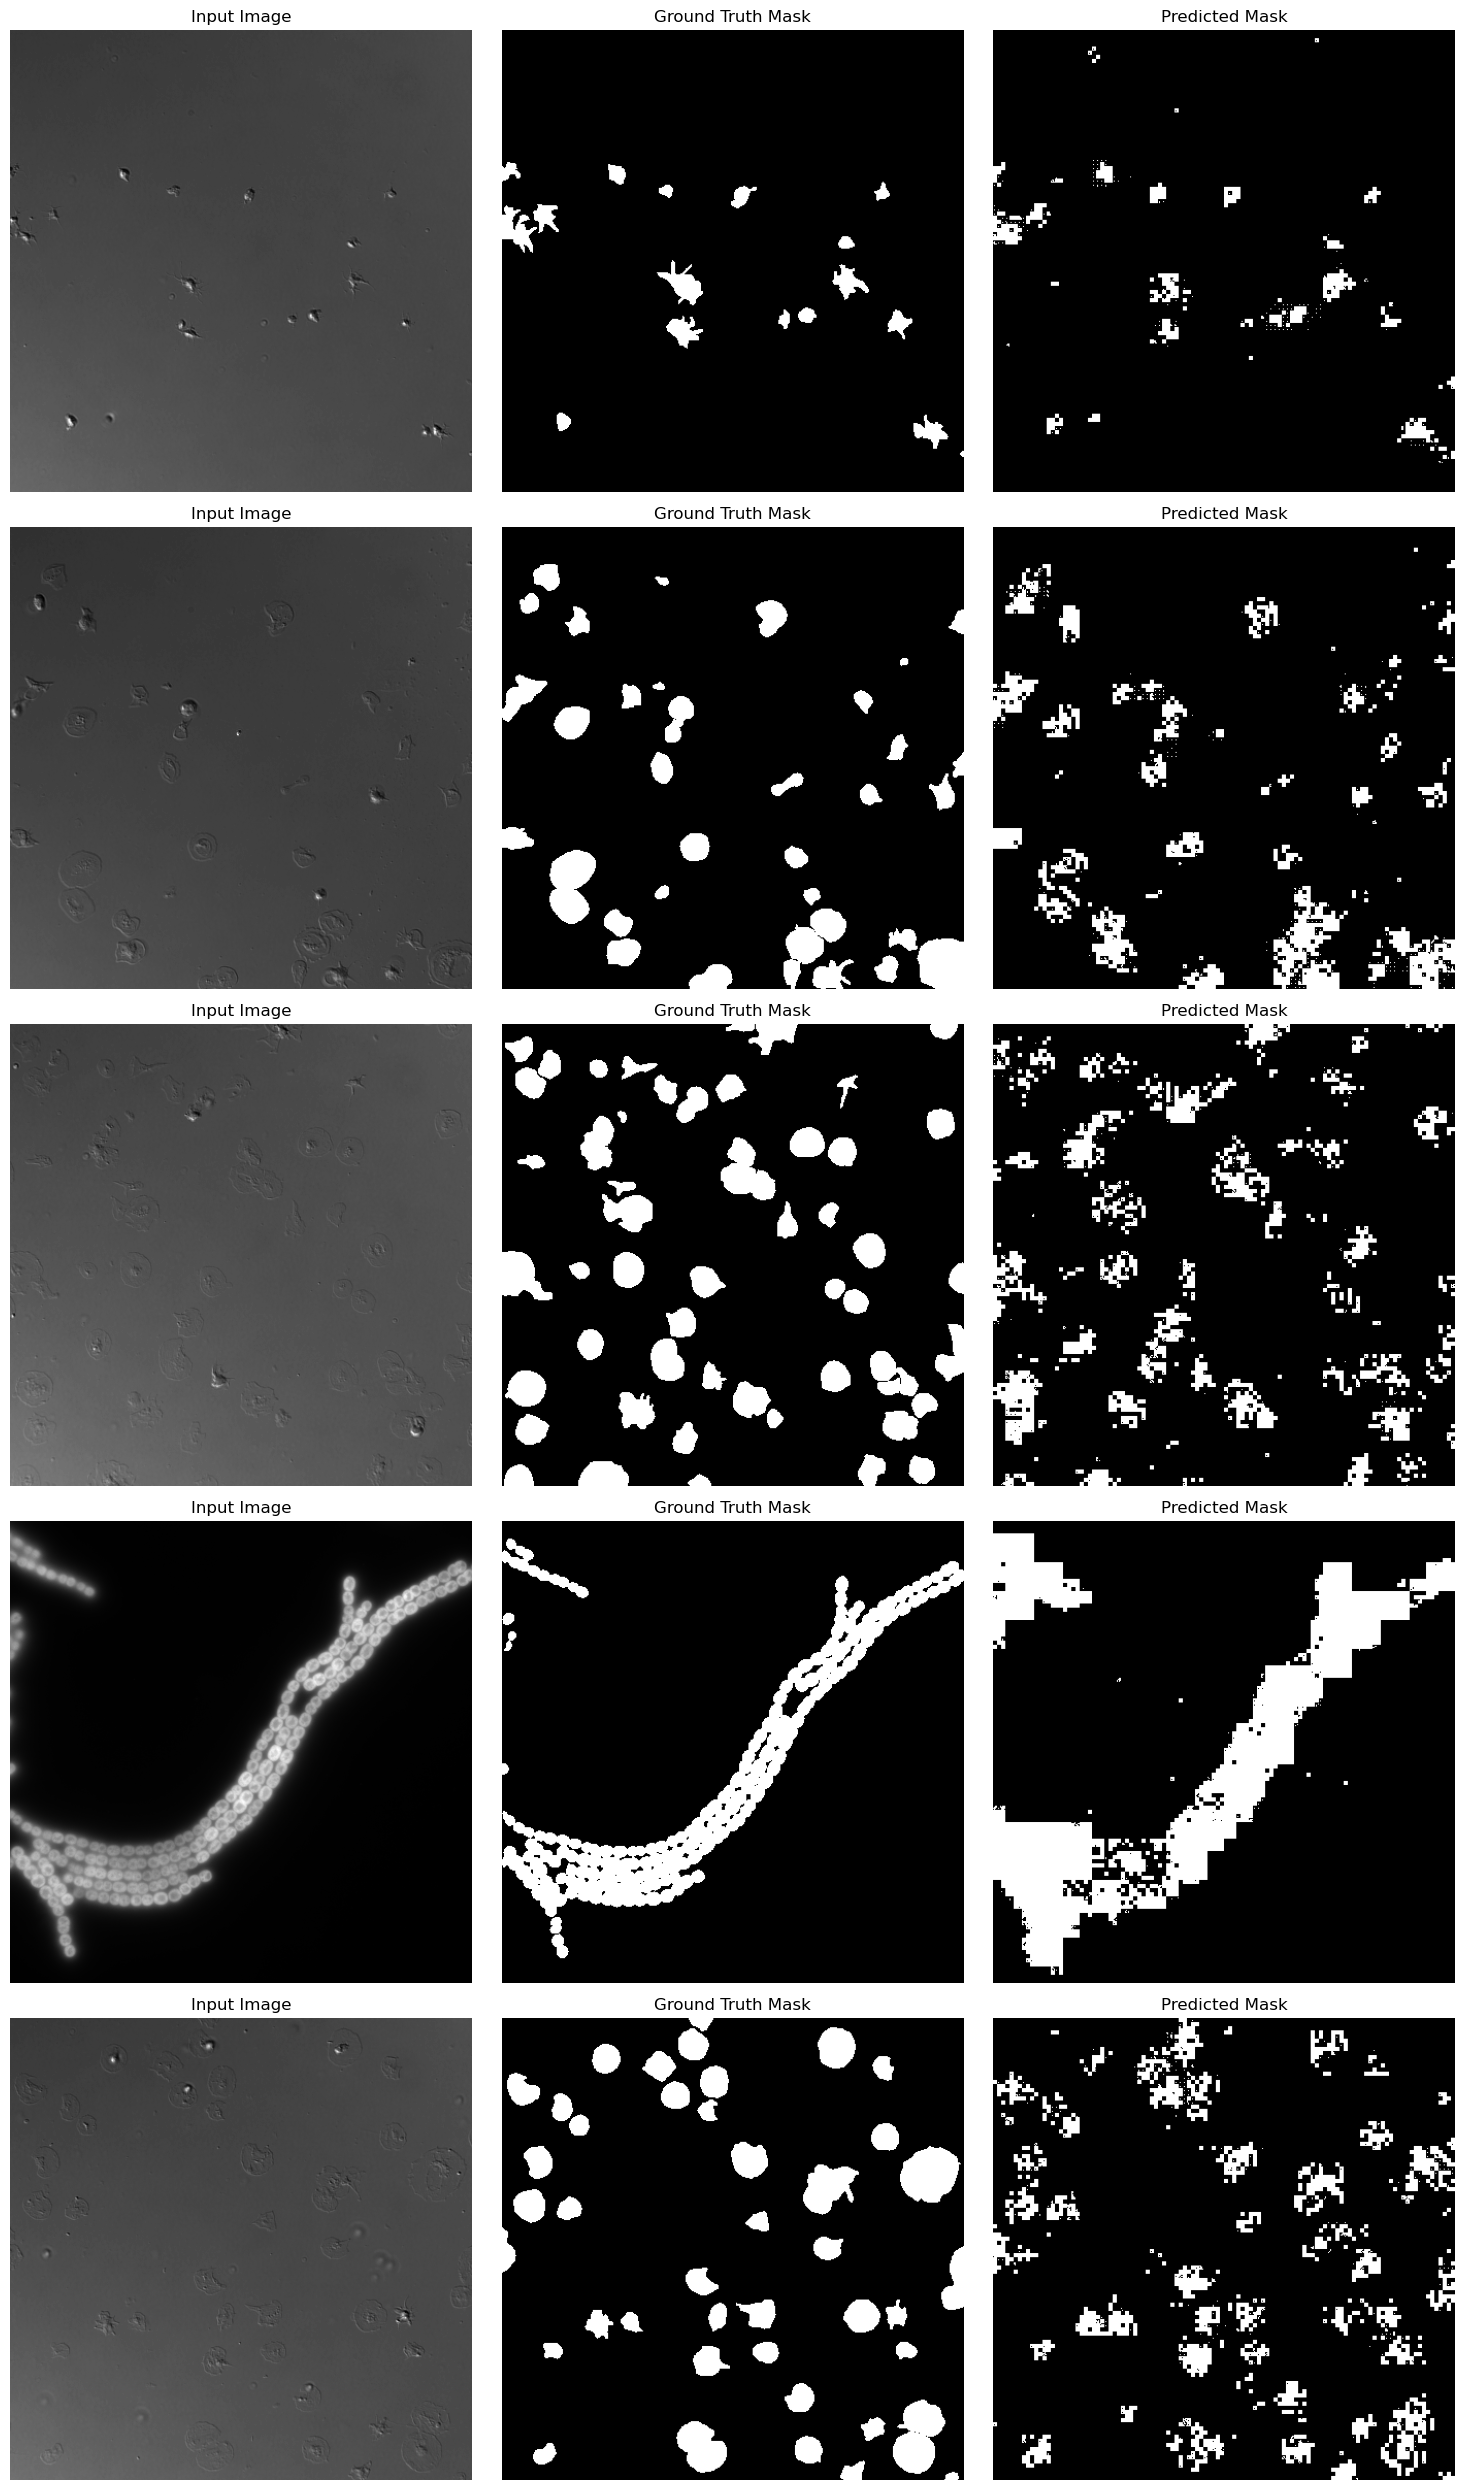

In [15]:

# Testing with the best model
print("\nLoading best model for testing...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
test_loss, test_iou, test_fscore = validate_one_epoch(model, test_loader, loss_fn, metrics, DEVICE)
print(f"\nTest Results -> Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F-score (Dice): {test_fscore:.4f}")

# Plot predictions
print("\nPlotting some test predictions...")
plot_predictions(model, test_dataset, DEVICE, num_samples=5)
